In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Directorio donde se encuentran las imágenes
data_dir = 'data/'

# Función para convertir imágenes en un DataFrame
def convert_img_to_df(dataset):
  img_dir = Path(dataset)
  # Lista de rutas de archivos de imágenes con extensión .jpg
  filename = list(img_dir.glob(r'**/*.jpg'))
  # Extraer etiquetas (nombres de las carpetas inmediatas) de las rutas de los archivos
  label = list(map(lambda x:os.path.split(os.path.split(x)[0])[1],filename))
  
  # Crear una serie de pandas a partir de las rutas de archivos con nombre 'Filepath'
  filename = pd.Series(filename,name='Filepath').astype(str)
  # Crear una serie de pandas a partir de las etiquetas con nombre 'Label'
  label = pd.Series(label,name='Label')
  # Concatenar las dos series en un DataFrame
  img_df = pd.concat([filename,label],axis=1)
  return img_df

img_df = convert_img_to_df(data_dir)
img_df.head()

,Filepath,Label
0,data\Angry\0346f330983a068db0633f96d4a13de873-...,Angry
1,data\Angry\1564075.jpg,Angry
2,data\Angry\19_1016_DISCIPLESHIP_How-to-Deal-Wi...,Angry
3,data\Angry\32209658.jpg,Angry
4,data\Angry\3710928.jpg,Angry


In [3]:
# Obtener y mostrar las dimensiones de la imagen (alto y ancho)
img = plt.imread(img_df['Filepath'].iloc[1])
img.shape

(1200, 1920, 3)

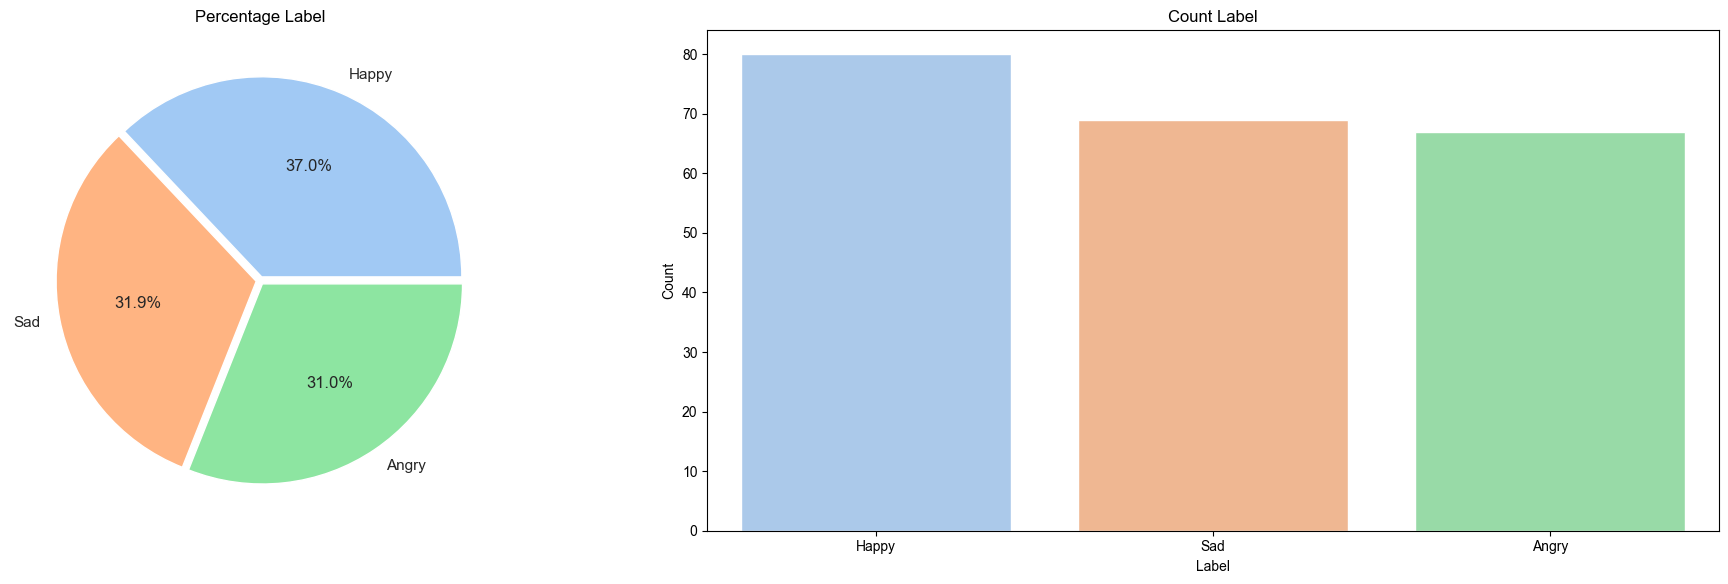

In [4]:
# Contar la cantidad de cada label
label_count = img_df['Label'].value_counts()

# Configuración para los gráficos
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count) # Lista de valores de desplazamiento para el gráfico de pastel

#Pie chart
axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

#Barplot
sns.barplot(x=label_count.index, y=label_count.values, ax=axes[1])
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

#Show
plt.tight_layout()
plt.show()

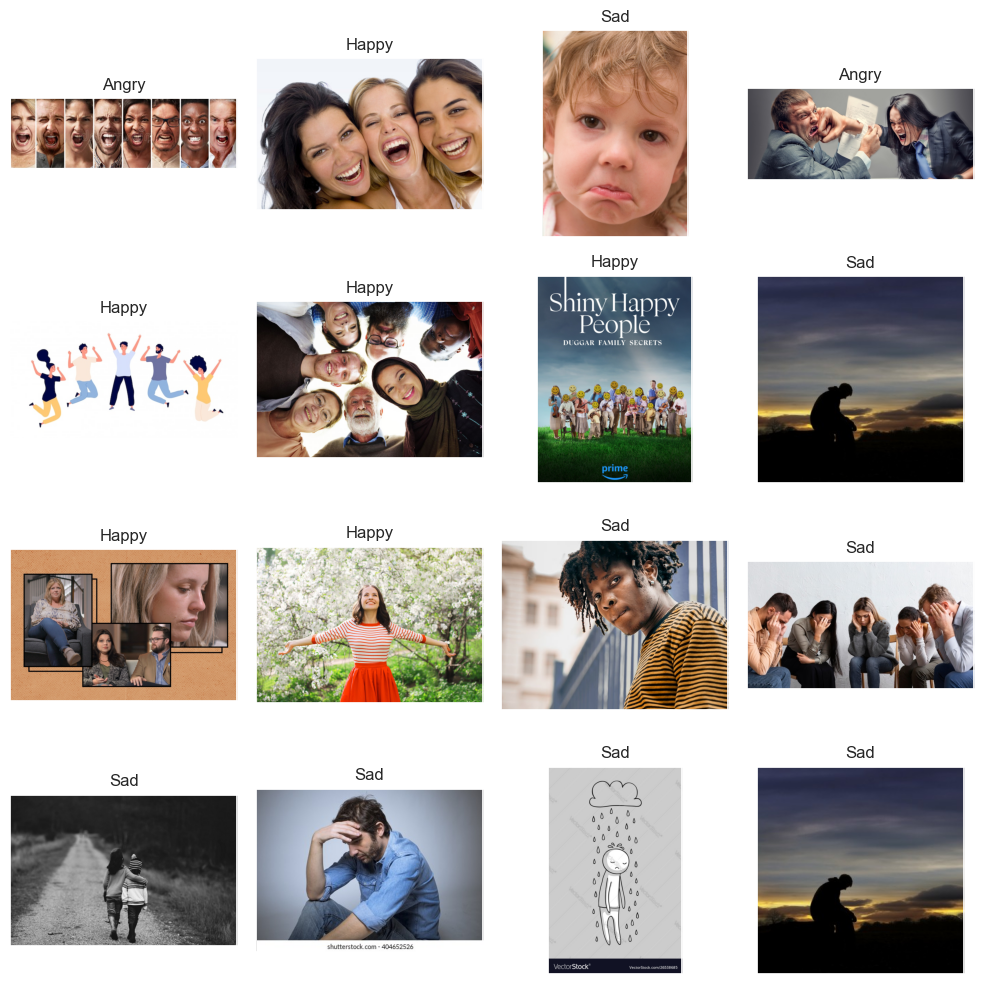

In [5]:
# Generar 16 índices aleatorios
random_index = np.random.randint(0,len(img_df),16)
# Crear plots 4x4
fig,axes = plt.subplots(nrows=4,ncols=4,figsize=(10,10),subplot_kw={'xticks':[],'yticks':[]})

# Cargar imagenes en cada 4x4 
for i,ax in enumerate(axes.flat):
  img = plt.imread(img_df['Filepath'].iloc[random_index[i]])
  ax.imshow(img)
  ax.set_title(img_df['Label'].iloc[random_index[i]])
plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento (img_train) y prueba (test) con una proporción del 90% y 10%
img_train , test = train_test_split(img_df, test_size=0.1)

# Dividir los datos en conjuntos de entrenamiento (img_train) y prueba (test) con una proporción del 90% y 10%
train, val = train_test_split(img_train,test_size=0.2)

In [7]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# Para el conjunto de entrenamiento
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             vertical_flip=True,
                             horizontal_flip=True)
# Para el conjunto de Test
datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)
# Crear conjuntos de datos de flujo de datos desde DataFrames para entrenamiento, validación y prueba
train_set = datagen.flow_from_dataframe(dataframe=train,
                                        x_col='Filepath', # Columna que contiene las rutas de archivo de las imágenes
                                        y_col= 'Label', # Columna que contiene las etiquetas de las imágenes
                                        batch_size=32,
                                        class_mode='categorical',
                                        seed = 42,
                                        shuffle=True,
                                        target_size=(224,224)) # Modo de clasificación categórica (etiquetas one-hot)

val_set = datagen_test.flow_from_dataframe(dataframe=val,
                                        x_col='Filepath',
                                        y_col= 'Label',
                                        batch_size=32,
                                        class_mode='categorical',
                                        seed = 42,
                                        shuffle=True,
                                        target_size=(224,224))

test_set = datagen_test.flow_from_dataframe(dataframe=test,
                                        x_col='Filepath',
                                        y_col= 'Label',
                                        batch_size=32,
                                        class_mode='categorical',
                                        seed = 42,
                                        shuffle=False,
                                        target_size=(224,224))

Found 155 validated image filenames belonging to 3 classes.
Found 39 validated image filenames belonging to 3 classes.
Found 22 validated image filenames belonging to 3 classes.


In [8]:
from keras import Sequential
from keras.layers import Dense, MaxPool2D,Conv2D,Flatten,Dropout

# Crear una instancia de VGG16 con pesos pre-entrenados en ImageNet
base_vgg = VGG16(weights='imagenet',
                   input_shape=(224,224,3),
                   include_top=False)
# Congelar las capas del modelo VGG16 pre-entrenado para evitar el entrenamiento de sus pesos
base_vgg.trainable = False
# Crear un modelo secuencial para agregar capas adicionales sobre el modelo VGG16
vgg_model = Sequential()
# Agregar el modelo VGG16 como la primera capa del nuevo modelo
vgg_model.add(base_vgg)
# Aplanar la salida de VGG16
vgg_model.add(Flatten())
# Agregar una capa densa (fully connected) con 128 neuronas y función de activación ReLU
vgg_model.add(Dense(128,activation='relu'))
# Agregar una capa de dropout con una tasa del 40% para evitar el sobreajuste
vgg_model.add(Dropout(0.4))
# Agregar una capa densa de salida con 3 neuronas y función de activación softmax (clasificación multiclase)
vgg_model.add(Dense(3,activation='softmax'))

# Compilar el modelo con la función de pérdida 'categorical_crossentropy', optimizador 'adam' y métrica de 'accuracy'
vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo con el conjunto de entrenamiento y validación
history_vgg = vgg_model.fit(train_set,
                                  steps_per_epoch=len(train_set), # Pasos por época (número de lotes)
                                  validation_data=val_set, # Conjunto de validación
                                  validation_steps=len(val_set), # Pasos de validación (número de lotes)
                                  epochs=20,
                                  verbose=1)

Epoch 1/20
5/5 [==============================] - 41s 8s/step - loss: 23.5046 - accuracy: 0.3806 - val_loss: 16.3406 - val_accuracy: 0.4359
Epoch 2/20
5/5 [==============================] - 45s 9s/step - loss: 11.2692 - accuracy: 0.5032 - val_loss: 6.9566 - val_accuracy: 0.5641
Epoch 3/20
5/5 [==============================] - 43s 9s/step - loss: 3.9836 - accuracy: 0.6323 - val_loss: 2.6959 - val_accuracy: 0.6154
Epoch 4/20
5/5 [==============================] - 39s 8s/step - loss: 2.3244 - accuracy: 0.7226 - val_loss: 2.2088 - val_accuracy: 0.6154
Epoch 5/20
5/5 [==============================] - 39s 8s/step - loss: 1.4910 - accuracy: 0.6323 - val_loss: 1.8037 - val_accuracy: 0.5897
Epoch 6/20
5/5 [==============================] - 35s 7s/step - loss: 0.6766 - accuracy: 0.6903 - val_loss: 1.7779 - val_accuracy: 0.5385
Epoch 7/20
5/5 [==============================] - 34s 7s/step - loss: 0.6475 - accuracy: 0.7097 - val_loss: 1.5141 - val_accuracy: 0.5641
Epoch 8/20
5/5 [===============

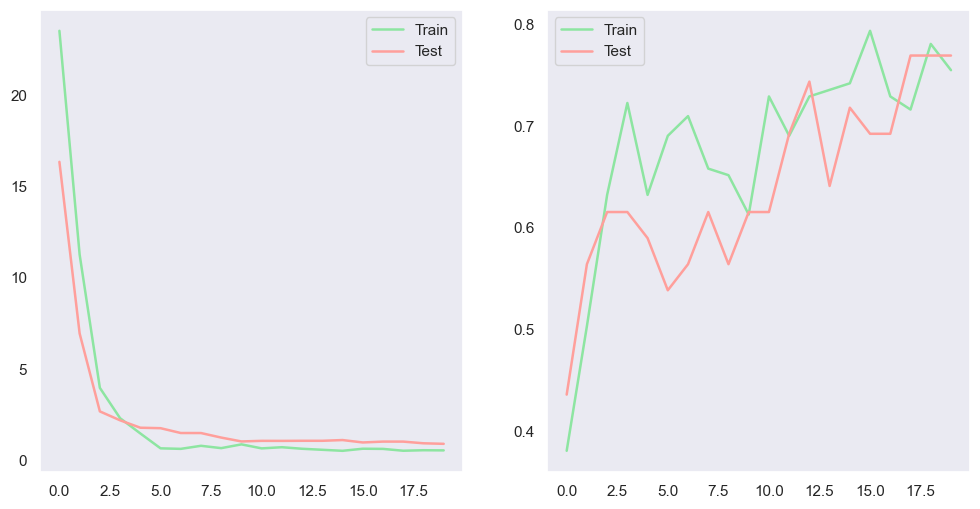

In [10]:
sns.set_theme(style='darkgrid',palette='pastel')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

# Graficar la pérdida de entrenamiento y prueba en la misma subtrama
plt.plot(history_vgg.history['loss'],label='Train',c='g',lw=1.8) # Pérdida de entrenamiento (verde)
plt.plot(history_vgg.history['val_loss'],label='Test',c='r',lw=1.8) # Pérdida de prueba (rojo)
plt.legend()
plt.grid()

plt.subplot(1,2,2)
# Graficar la precisión de entrenamiento y prueba en la misma subtrama
plt.plot(history_vgg.history['accuracy'],label='Train',c='g',lw=1.8) # Precisión de entrenamiento (verde)
plt.plot(history_vgg.history['val_accuracy'],label='Test',c='r',lw=1.8) # Precisión de prueba (rojo)
plt.legend()
plt.grid()

plt.show()

In [11]:
# Evaluar el modelo
score =vgg_model.evaluate(test_set,steps=len(test_set),verbose=0)
print('Loss: {:.2f}'.format(score[0]))
print('Accuracy: {:.2f}'.format(score[1]))

Loss: 1.62
Accuracy: 0.55


In [12]:
# Realizar predicciones en el conjunto de prueba 
pred = vgg_model.predict(test_set)
# Obtener las etiquetas predichas tomando el índice de la clase con la mayor probabilidad
pred = np.argmax(pred,axis=1)
# Mostrar las etiquetas predichas de las primeras 5 muestras
pred[:5]

1/1 [==============================] - 3s 3s/step


array([2, 2, 0, 1, 2], dtype=int64)

In [13]:
# Obtener el mapeo entre etiquetas y sus índices en el conjunto de prueba
labels = (test_set.class_indices)
# Crear un nuevo diccionario invirtiendo las claves (índices) y valores (etiquetas)
labels = dict((v,k) for k,v in labels.items())

In [14]:
# Convertir las etiquetas numéricas predichas en etiquetas de clase utilizando el diccionario
pred = [labels[k] for k in pred]
# Mostrar las etiquetas de clase predichas de las primeras 5 muestras
pred[:5]

['Sad', 'Sad', 'Angry', 'Happy', 'Sad']

In [15]:
from sklearn.metrics import accuracy_score,classification_report

# Obtener las etiquetas reales del conjunto de prueba
y_test = list(test.Label)

# Calcular y mostrar la precisión del modelo en el conjunto de prueba
print('Accuracy Score: {:.3f}'.format(accuracy_score(y_test,pred)))

# Generar y mostrar un informe de clasificación que incluye métricas como precisión, recuperación y F1-score
print(classification_report(y_test,pred))

Accuracy Score: 0.545
              precision    recall  f1-score   support

       Angry       0.29      0.29      0.29         7
       Happy       0.71      0.62      0.67         8
         Sad       0.62      0.71      0.67         7

    accuracy                           0.55        22
   macro avg       0.54      0.54      0.54        22
weighted avg       0.55      0.55      0.55        22



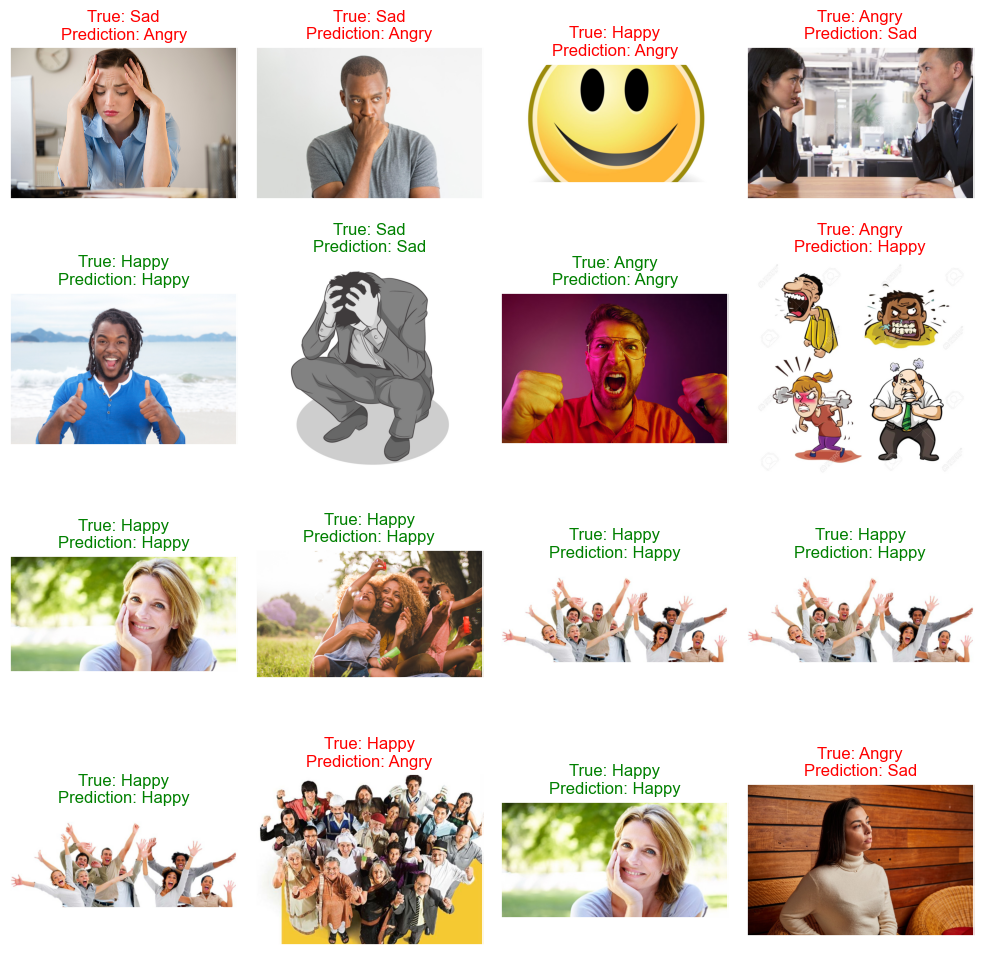

In [16]:
# Seleccionar 16 índices aleatorios del conjunto de prueba
index_random = np.random.randint(0,len(test),16)

# Plot de  4x4
fig,axes = plt.subplots(nrows=4, ncols=4,figsize=(10,10),subplot_kw={'xticks':[],'yticks':[]})

# Iterar en el plot y mostrar las etiquetas reales y predichas
for i ,ax in enumerate(axes.flat):
  img = plt.imread(test['Filepath'].iloc[index_random[i]]) # Cargar la imagen en el índice aleatorio
  ax.imshow(img) # Mostrar la imagen

  # Verificar si la predicción es correcta y asignar un color apropiado al título
  if test['Label'].iloc[index_random[i]] == pred[index_random[i]]:
    color = 'green'  # Predicción correcta
  else:
    color = 'red' # Predicción incorrecta
  ax.set_title(f'True: {test.Label.iloc[index_random[i]]}\nPrediction: {pred[index_random[i]]}',color=color)

plt.tight_layout()
plt.show()